In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 723.1/723.1 kB 17.0 MB/s eta 0:00:0000:01


In [2]:
import ultralytics
from ultralytics import YOLO
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import wandb
wandb.init(mode="disabled")
import shutil

In [3]:
if os.path.exists('dataset'):
    shutil.rmtree('dataset')
shutil.copytree('/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/', 'dataset')

'dataset'

In [6]:
files = os.listdir('dataset/images/train')
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]
print(random_file)

00271_124


(256, 192, 3)


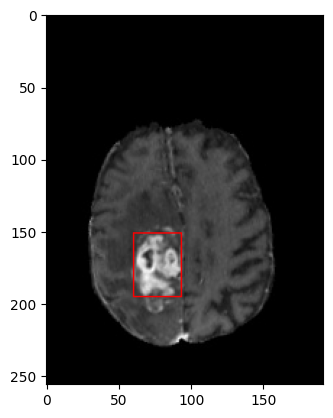

In [7]:
with open(os.path.join('dataset/labels/train', f'{random_file}.txt'),'r') as f:
    labels = f.readlines()
    labels = labels[0].split(' ')
    f.close()

img = cv2.imread(os.path.join('dataset/images/train', f'{random_file}.jpg'), 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
x_pt1 = int((x - w/2) * img.shape[1])
y_pt1 = int((y - h/2) * img.shape[0])
x_pt2 = int((x + w/2) * img.shape[1])
y_pt2 = int((y + h/2) * img.shape[0])

if tumor_class == 1:
    colour = (255, 0, 0)
else:
    colour = (0, 255, 0)
cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)

print(img.shape)
plt.imshow(img)

In [8]:
train_images = os.listdir('dataset/images/train')
test_images = os.listdir('dataset/images/test')
train_labels = os.listdir('dataset/labels/train')
test_labels = os.listdir('dataset/labels/test')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

310 75
296 75


In [9]:
os.path.splitext(random_file)[0]
unlabelled = set(train_images) - set([os.path.splitext(file)[0] + '.jpg' for file in train_labels])

for image in unlabelled:
    os.remove(os.path.join('dataset/images/train', image))

In [10]:
train_images = os.listdir('dataset/images/train')
test_images = os.listdir('dataset/images/test')
train_labels = os.listdir('dataset/labels/train')
test_labels = os.listdir('dataset/labels/test')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

296 75
296 75


In [11]:
val_split = int(num_train_images * 0.2)
val_images = random.sample(train_images, val_split)

if os.path.exists('dataset/images/val'):
    shutil.rmtree('dataset/images/val')
if os.path.exists('dataset/labels/val'):
    shutil.rmtree('dataset/labels/val')

os.mkdir('./dataset/images/val')
os.mkdir('./dataset/labels/val')

for image in val_images:
    shutil.move(os.path.join('dataset/images/train', image), 'dataset/images/val')

for image in val_images:
    label = os.path.splitext(image)[0] + '.txt'
    shutil.move(os.path.join('dataset/labels/train', label), 'dataset/labels/val')

In [12]:
text = """
path: /kaggle/working/dataset
train: images/train
val: images/val

# Classes
nc: 2
names: ['negative','positive']
"""
with open("./fixed_path.yaml", 'w') as file:
    file.write(text)

In [13]:
model = YOLO('yolov5nu.pt')

100%|██████████| 5.27M/5.27M [00:00<00:00, 85.7MB/s]


In [14]:
results = model.train(data='/kaggle/working/fixed_path.yaml', epochs=200, device=0)

Ultralytics YOLOv8.1.35 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov5nu.pt, data=/kaggle/working/fixed_path.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=T

100%|██████████| 755k/755k [00:00<00:00, 18.2MB/s]
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1760  ultralytics.nn.modules.conv.Conv             [3, 16, 6, 2, 2]              
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      4800  ultralytics.nn.modules.block.C3              [32, 32, 1]                   
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     29184  ultralytics.nn.modules.block.C3              [64, 64, 2]                   
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  3    156928  ultralytics.nn.modules.block.C3              [128, 128, 3]                 
  7                  -1  1    295424  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 105MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/dataset/labels/train... 237 images, 0 backgrounds, 0 corrupt: 100%|██████████| 237/237 [00:00<00:00, 1386.80it/s]

train: New cache created: /kaggle/working/dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/dataset/labels/val... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<00:00, 1329.74it/s]

val: New cache created: /kaggle/working/dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      2.28G      1.485      4.424      1.304         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         59         64    0.00328      0.907      0.135     0.0826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200       2.3G      1.222      2.829      1.065         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.17it/s]

                   all         59         64    0.00344      0.954       0.39      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.31G      1.184      2.346      1.085         27        640: 100%|██████████| 15/15 [00:02<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]

                   all         59         64      0.344      0.536      0.314      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      2.31G      1.238      2.265       1.13         20        640: 100%|██████████| 15/15 [00:02<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.79it/s]

                   all         59         64      0.814     0.0541       0.35      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      2.31G      1.136      2.102      1.072         18        640: 100%|██████████| 15/15 [00:02<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.70it/s]

                   all         59         64      0.482      0.135      0.359      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      2.31G       1.17      2.008      1.082         22        640: 100%|██████████| 15/15 [00:02<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.79it/s]

                   all         59         64      0.351      0.462      0.368      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200       2.3G      1.167      1.895      1.101         25        640: 100%|██████████| 15/15 [00:02<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.49it/s]

                   all         59         64      0.477      0.703      0.576      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      2.31G      1.173      1.877      1.101         25        640: 100%|██████████| 15/15 [00:02<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.26it/s]

                   all         59         64      0.497      0.444      0.457      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      2.31G      1.215      1.826      1.117         29        640: 100%|██████████| 15/15 [00:02<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

                   all         59         64      0.262      0.437      0.326       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      2.31G      1.195      1.857      1.122         17        640: 100%|██████████| 15/15 [00:02<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

                   all         59         64      0.364      0.692      0.439      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200       2.3G      1.129      1.672        1.1         29        640: 100%|██████████| 15/15 [00:02<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

                   all         59         64      0.469      0.449      0.425      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      2.31G      1.132      1.508      1.106         25        640: 100%|██████████| 15/15 [00:02<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]

                   all         59         64      0.591      0.766      0.739      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      2.31G      1.135      1.447      1.077         26        640: 100%|██████████| 15/15 [00:02<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.48it/s]

                   all         59         64      0.614      0.744      0.787      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      2.31G        1.1      1.423      1.068         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

                   all         59         64      0.671      0.653      0.696      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200       2.3G      1.107      1.364      1.084         18        640: 100%|██████████| 15/15 [00:02<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.17it/s]

                   all         59         64      0.692      0.641      0.692      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      2.31G      1.085      1.329      1.067         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]

                   all         59         64      0.825      0.694      0.823      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      2.31G      1.089      1.316      1.069         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

                   all         59         64      0.654      0.659      0.709      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      2.31G      1.064      1.246       1.04         26        640: 100%|██████████| 15/15 [00:02<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]

                   all         59         64       0.52      0.688      0.528      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200       2.3G      1.036      1.244      1.053         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]

                   all         59         64      0.636      0.792       0.79      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200       2.3G      1.017      1.126      1.025         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]

                   all         59         64      0.766      0.813       0.85      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200       2.3G     0.9617      1.021      1.012         20        640: 100%|██████████| 15/15 [00:02<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]

                   all         59         64      0.791      0.749      0.837      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200       2.3G      1.017      1.025      1.037         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         59         64      0.755      0.803      0.875        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200       2.3G      1.043      1.038      1.054         18        640: 100%|██████████| 15/15 [00:02<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.60it/s]

                   all         59         64      0.889       0.85      0.901      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200       2.3G      1.014      1.021      1.046         25        640: 100%|██████████| 15/15 [00:02<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.75it/s]

                   all         59         64      0.591      0.723      0.753      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200       2.3G       1.07       1.05      1.069         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

                   all         59         64      0.707      0.774      0.806      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200       2.3G      1.046      1.006      1.018         19        640: 100%|██████████| 15/15 [00:03<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

                   all         59         64       0.75      0.741      0.796      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200       2.3G      1.001     0.9443      1.018         22        640: 100%|██████████| 15/15 [00:02<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

                   all         59         64      0.718      0.804      0.843      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200       2.3G     0.9989     0.9561      1.038         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

                   all         59         64      0.755      0.803      0.863      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200       2.3G     0.9524     0.8526      1.007         26        640: 100%|██████████| 15/15 [00:02<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         59         64      0.693      0.843      0.833       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200       2.3G     0.9223     0.8866      1.007         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]

                   all         59         64      0.654      0.715      0.744      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200       2.3G     0.9758     0.9167      1.023         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.62it/s]

                   all         59         64      0.845      0.804      0.904      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200       2.3G     0.9476     0.8671       1.01         26        640: 100%|██████████| 15/15 [00:02<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.53it/s]

                   all         59         64      0.887      0.799      0.895      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200       2.3G     0.9555     0.8656      1.009         18        640: 100%|██████████| 15/15 [00:02<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.13it/s]

                   all         59         64      0.794      0.799      0.892       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200       2.3G      0.982     0.9146      1.034         22        640: 100%|██████████| 15/15 [00:02<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]

                   all         59         64      0.784      0.839      0.903      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200       2.3G     0.9958     0.8965      1.048         13        640: 100%|██████████| 15/15 [00:02<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]

                   all         59         64       0.61      0.644      0.661      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200       2.3G     0.9898     0.8856      1.027         25        640: 100%|██████████| 15/15 [00:02<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.45it/s]

                   all         59         64      0.814      0.725      0.841      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200       2.3G     0.9558     0.8275      1.018         17        640: 100%|██████████| 15/15 [00:02<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.03it/s]

                   all         59         64      0.621      0.811      0.792      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200       2.3G     0.9923     0.9099      1.025         24        640: 100%|██████████| 15/15 [00:02<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

                   all         59         64      0.759      0.746      0.828      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200       2.3G     0.9631     0.8633      1.033         27        640: 100%|██████████| 15/15 [00:02<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]

                   all         59         64      0.687      0.718      0.772      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200       2.3G      0.937     0.8431      1.001         18        640: 100%|██████████| 15/15 [00:02<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.08it/s]

                   all         59         64      0.783      0.681      0.687      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200       2.3G     0.8872     0.7786      0.977         29        640: 100%|██████████| 15/15 [00:02<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]

                   all         59         64      0.682      0.737      0.894      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200       2.3G     0.9538     0.8286     0.9943         18        640: 100%|██████████| 15/15 [00:02<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]

                   all         59         64      0.871      0.845      0.905      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200       2.3G     0.9165     0.7895     0.9933         20        640: 100%|██████████| 15/15 [00:02<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.09it/s]

                   all         59         64      0.779      0.724       0.84      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200       2.3G     0.9352     0.7953     0.9996         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.43it/s]

                   all         59         64      0.716       0.74      0.792      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200       2.3G     0.8938     0.7445     0.9819         27        640: 100%|██████████| 15/15 [00:02<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.15it/s]

                   all         59         64      0.852      0.781      0.893       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200       2.3G     0.9193     0.8232     0.9931         31        640: 100%|██████████| 15/15 [00:02<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.20it/s]

                   all         59         64      0.679      0.742       0.78      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200       2.3G     0.9067     0.7686     0.9883         26        640: 100%|██████████| 15/15 [00:02<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]

                   all         59         64      0.693      0.589      0.632      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200       2.3G     0.9144     0.7102      0.982         30        640: 100%|██████████| 15/15 [00:02<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]

                   all         59         64       0.72      0.779      0.855      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200       2.3G     0.8743     0.7014     0.9632         17        640: 100%|██████████| 15/15 [00:02<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

                   all         59         64      0.817       0.84      0.896      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200       2.3G     0.8893     0.7236     0.9891         22        640: 100%|██████████| 15/15 [00:02<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]

                   all         59         64      0.652      0.884      0.894      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200       2.3G     0.9007     0.7282     0.9913         29        640: 100%|██████████| 15/15 [00:02<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         59         64       0.85      0.794      0.887      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200       2.3G     0.8797     0.6926     0.9687         18        640: 100%|██████████| 15/15 [00:02<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.28it/s]

                   all         59         64      0.905      0.904      0.926      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200       2.3G     0.8751      0.698     0.9864         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]

                   all         59         64      0.853      0.779      0.923       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200       2.3G      0.853      0.678      0.967         24        640: 100%|██████████| 15/15 [00:02<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

                   all         59         64      0.732      0.846      0.888       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200       2.3G     0.8376     0.6788     0.9596         28        640: 100%|██████████| 15/15 [00:02<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         59         64       0.75      0.805      0.872      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200       2.3G      0.863     0.6981     0.9831         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         59         64      0.901      0.814      0.902      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200       2.3G     0.8801     0.6872     0.9723         20        640: 100%|██████████| 15/15 [00:02<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]

                   all         59         64      0.909      0.803      0.923       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200       2.3G     0.8718     0.6719      0.985         17        640: 100%|██████████| 15/15 [00:02<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.14it/s]

                   all         59         64       0.81      0.855      0.896      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200       2.3G     0.9416     0.7066      1.014         24        640: 100%|██████████| 15/15 [00:02<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.28it/s]

                   all         59         64      0.634      0.649      0.611       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200       2.3G     0.9084      0.703     0.9926         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

                   all         59         64      0.708      0.824      0.845      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200       2.3G      0.859     0.6545     0.9718         27        640: 100%|██████████| 15/15 [00:02<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

                   all         59         64      0.858      0.874       0.95      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200       2.3G     0.8664     0.6628     0.9761         20        640: 100%|██████████| 15/15 [00:02<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]

                   all         59         64       0.87       0.85      0.901      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200       2.3G     0.8544     0.6366     0.9728         18        640: 100%|██████████| 15/15 [00:02<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.56it/s]

                   all         59         64      0.837      0.863      0.927      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200       2.3G     0.8285     0.6321     0.9749         18        640: 100%|██████████| 15/15 [00:02<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]

                   all         59         64      0.835      0.857      0.929      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200       2.3G     0.8194     0.6556     0.9764         18        640: 100%|██████████| 15/15 [00:02<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]

                   all         59         64      0.902       0.87      0.943      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200       2.3G       0.82     0.6242     0.9688         18        640: 100%|██████████| 15/15 [00:02<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]

                   all         59         64      0.663      0.754      0.703      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200       2.3G     0.8843     0.7344     0.9859         20        640: 100%|██████████| 15/15 [00:02<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]

                   all         59         64      0.783      0.724      0.848      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200       2.3G     0.8707     0.6599     0.9738         25        640: 100%|██████████| 15/15 [00:02<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.75it/s]

                   all         59         64      0.861      0.836      0.922      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200       2.3G     0.8698      0.628     0.9728         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]

                   all         59         64      0.896      0.936      0.967      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200       2.3G     0.8494     0.6327     0.9618         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]

                   all         59         64      0.919      0.841      0.956      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200       2.3G      0.787     0.6292     0.9468         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]

                   all         59         64      0.811      0.834      0.881       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200       2.3G     0.8425     0.6589     0.9872         24        640: 100%|██████████| 15/15 [00:02<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.10it/s]

                   all         59         64      0.918      0.911      0.951      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200       2.3G      0.822     0.6262     0.9431         28        640: 100%|██████████| 15/15 [00:02<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]

                   all         59         64      0.939       0.84      0.937      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200       2.3G     0.8529     0.6089     0.9797         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

                   all         59         64      0.899      0.877      0.947      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200       2.3G     0.7879     0.6195     0.9602         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]

                   all         59         64      0.933      0.904      0.952      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200       2.3G     0.7884     0.6011     0.9619         28        640: 100%|██████████| 15/15 [00:02<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]

                   all         59         64      0.918      0.829      0.926      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200       2.3G     0.8134     0.5822     0.9608         24        640: 100%|██████████| 15/15 [00:02<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.83it/s]

                   all         59         64      0.896      0.949      0.945      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200       2.3G     0.8076     0.5871     0.9808         20        640: 100%|██████████| 15/15 [00:02<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]

                   all         59         64      0.841      0.919      0.946       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200       2.3G     0.7823     0.6005     0.9499         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]

                   all         59         64      0.861      0.926      0.951      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200       2.3G     0.8167     0.5623     0.9639         25        640: 100%|██████████| 15/15 [00:02<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.41it/s]

                   all         59         64        0.8      0.841      0.817      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200       2.3G     0.8232     0.6022     0.9827         16        640: 100%|██████████| 15/15 [00:02<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]

                   all         59         64      0.843      0.821      0.902      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200       2.3G      0.853     0.6062     0.9589         33        640: 100%|██████████| 15/15 [00:02<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]

                   all         59         64      0.828      0.922      0.928      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200       2.3G     0.8023      0.583     0.9532         22        640: 100%|██████████| 15/15 [00:02<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.82it/s]

                   all         59         64      0.813      0.876      0.935      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200       2.3G     0.7466      0.566     0.9334         20        640: 100%|██████████| 15/15 [00:02<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.68it/s]

                   all         59         64      0.853       0.88      0.922      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200       2.3G     0.7588     0.5574     0.9506         28        640: 100%|██████████| 15/15 [00:02<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.91it/s]

                   all         59         64      0.861      0.841       0.87       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200       2.3G     0.7701     0.5433     0.9444         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

                   all         59         64      0.808      0.881        0.9      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200       2.3G     0.7678     0.5287     0.9496         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]

                   all         59         64      0.914      0.858      0.919      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200       2.3G     0.7459     0.5199     0.9419         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]

                   all         59         64      0.772      0.808      0.827      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200       2.3G     0.7422      0.512     0.9276         17        640: 100%|██████████| 15/15 [00:02<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]

                   all         59         64      0.824      0.804      0.869      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200       2.3G     0.7782     0.5571      0.949         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.07it/s]

                   all         59         64      0.912      0.909      0.943      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200       2.3G      0.745     0.5403     0.9357         24        640: 100%|██████████| 15/15 [00:02<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.39it/s]

                   all         59         64      0.912      0.883      0.947      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200       2.3G     0.7776      0.547     0.9656         18        640: 100%|██████████| 15/15 [00:02<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]

                   all         59         64      0.924      0.885      0.949      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200       2.3G     0.7939     0.5509     0.9494         24        640: 100%|██████████| 15/15 [00:02<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]

                   all         59         64      0.851      0.823      0.927      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200       2.3G     0.7893     0.5516     0.9484         18        640: 100%|██████████| 15/15 [00:02<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]

                   all         59         64      0.763      0.783      0.868      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200       2.3G      0.786     0.5464     0.9395         20        640: 100%|██████████| 15/15 [00:02<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]

                   all         59         64       0.81      0.838      0.877      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200       2.3G     0.7536     0.5353     0.9503         22        640: 100%|██████████| 15/15 [00:02<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]

                   all         59         64      0.896      0.806      0.884      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200       2.3G     0.7542     0.5177     0.9332         27        640: 100%|██████████| 15/15 [00:02<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

                   all         59         64      0.937      0.879      0.945      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200       2.3G      0.723     0.4918     0.9354         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

                   all         59         64      0.956      0.936      0.969      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200       2.3G     0.7181     0.5154     0.9175         24        640: 100%|██████████| 15/15 [00:02<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

                   all         59         64      0.943       0.89      0.956      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200       2.3G     0.7565     0.5296     0.9314         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.26it/s]

                   all         59         64        0.9       0.84      0.929      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200       2.3G      0.748     0.5116     0.9572         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]

                   all         59         64      0.818       0.86      0.908      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200       2.3G     0.7404     0.5036     0.9412         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         59         64      0.784      0.895      0.953      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200       2.3G     0.7519     0.5275     0.9332         25        640: 100%|██████████| 15/15 [00:02<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.84it/s]

                   all         59         64       0.96       0.89      0.957      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200       2.3G     0.7272     0.5205     0.9442         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         59         64      0.925      0.901      0.962      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200       2.3G     0.7113     0.4887      0.932         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

                   all         59         64       0.99      0.895      0.976      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200       2.3G     0.7247     0.4785     0.9293         20        640: 100%|██████████| 15/15 [00:02<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]

                   all         59         64      0.878      0.922      0.961      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200       2.3G     0.7449     0.5129     0.9318         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

                   all         59         64      0.923      0.789      0.924      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200       2.3G     0.7013     0.4761     0.9153         27        640: 100%|██████████| 15/15 [00:02<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.49it/s]

                   all         59         64      0.915      0.927      0.973       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200       2.3G      0.762     0.4944     0.9234         17        640: 100%|██████████| 15/15 [00:02<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

                   all         59         64      0.816      0.863      0.957      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200       2.3G     0.6967     0.4836     0.9111         22        640: 100%|██████████| 15/15 [00:02<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

                   all         59         64      0.694      0.762      0.789      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200       2.3G     0.6987     0.4841     0.9438         28        640: 100%|██████████| 15/15 [00:02<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.53it/s]

                   all         59         64       0.85      0.709      0.866      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200       2.3G     0.6925     0.4762     0.9158         22        640: 100%|██████████| 15/15 [00:02<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]

                   all         59         64      0.867      0.849      0.908      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200       2.3G     0.6756     0.4458     0.9091         28        640: 100%|██████████| 15/15 [00:02<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.50it/s]

                   all         59         64      0.936      0.843      0.935      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200       2.3G     0.6884     0.4968     0.9117         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.09it/s]

                   all         59         64      0.945      0.859      0.939      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200       2.3G     0.6973     0.4686     0.9283         22        640: 100%|██████████| 15/15 [00:02<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.32it/s]

                   all         59         64      0.806       0.88      0.902      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200       2.3G     0.6939     0.4679     0.9352         20        640: 100%|██████████| 15/15 [00:02<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.22it/s]

                   all         59         64      0.847      0.936      0.956      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200       2.3G     0.6857     0.4858     0.9304         22        640: 100%|██████████| 15/15 [00:02<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.21it/s]

                   all         59         64      0.928        0.9      0.967      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200       2.3G      0.684     0.4595     0.9297         18        640: 100%|██████████| 15/15 [00:02<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

                   all         59         64      0.978      0.872      0.964      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200       2.3G     0.6893     0.4851     0.9133         29        640: 100%|██████████| 15/15 [00:02<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]

                   all         59         64       0.89      0.895      0.953      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200       2.3G     0.6596     0.4505      0.914         29        640: 100%|██████████| 15/15 [00:02<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.17it/s]

                   all         59         64      0.879      0.856      0.927      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200       2.3G     0.6858     0.4781     0.9149         17        640: 100%|██████████| 15/15 [00:02<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

                   all         59         64       0.92      0.858      0.941       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200       2.3G     0.6813     0.4579     0.9151         25        640: 100%|██████████| 15/15 [00:02<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.04it/s]

                   all         59         64      0.956      0.875       0.96      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200       2.3G      0.667     0.4491     0.9055         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]

                   all         59         64      0.939      0.848      0.961      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200       2.3G     0.6858     0.4645      0.929         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]

                   all         59         64      0.982      0.904      0.978      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200       2.3G     0.6627     0.4298     0.8985         15        640: 100%|██████████| 15/15 [00:02<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]

                   all         59         64      0.938      0.959      0.984       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200       2.3G     0.6779       0.46     0.9285         20        640: 100%|██████████| 15/15 [00:02<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.02it/s]

                   all         59         64      0.915      0.937      0.958      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200       2.3G     0.6406     0.4404     0.8958         25        640: 100%|██████████| 15/15 [00:02<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]

                   all         59         64      0.881      0.923      0.954      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200       2.3G     0.6507     0.4228     0.9021         26        640: 100%|██████████| 15/15 [00:02<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]

                   all         59         64      0.878       0.92      0.952      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200       2.3G     0.6764     0.4424     0.9136         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]

                   all         59         64      0.929      0.857      0.957      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200       2.3G     0.6884     0.4779     0.8979         16        640: 100%|██████████| 15/15 [00:02<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         59         64        0.9      0.949      0.953       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200       2.3G     0.6791     0.4591     0.9227         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]

                   all         59         64      0.979      0.899      0.967      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200       2.3G     0.6302     0.4344     0.9004         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]

                   all         59         64      0.937      0.909      0.962      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200       2.3G     0.6293     0.4195     0.8858         25        640: 100%|██████████| 15/15 [00:02<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

                   all         59         64      0.914      0.951      0.971      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200       2.3G     0.6316     0.4619     0.8997         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.20it/s]

                   all         59         64      0.866      0.951      0.967      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200       2.3G     0.6524     0.4588     0.9051         28        640: 100%|██████████| 15/15 [00:02<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.65it/s]

                   all         59         64      0.941      0.927      0.971      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200       2.3G     0.6587     0.4186     0.9046         24        640: 100%|██████████| 15/15 [00:02<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]

                   all         59         64       0.97      0.885       0.97      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200       2.3G     0.6181      0.431     0.8829         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.43it/s]

                   all         59         64      0.893      0.968       0.97      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200       2.3G     0.6497     0.4187     0.9237         15        640: 100%|██████████| 15/15 [00:02<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]

                   all         59         64      0.972      0.925      0.977      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200       2.3G     0.6351     0.4518     0.9081         20        640: 100%|██████████| 15/15 [00:02<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]

                   all         59         64       0.98      0.922      0.976      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200       2.3G      0.614     0.4278     0.8847         25        640: 100%|██████████| 15/15 [00:02<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]

                   all         59         64      0.893       0.91      0.968      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200       2.3G     0.6434     0.4241     0.8972         18        640: 100%|██████████| 15/15 [00:02<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]

                   all         59         64      0.887      0.888      0.947      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200       2.3G      0.619      0.423     0.8952         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.43it/s]

                   all         59         64      0.888      0.874       0.93      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200       2.3G     0.6314     0.4257     0.8916         16        640: 100%|██████████| 15/15 [00:02<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]

                   all         59         64      0.911      0.924      0.956       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200       2.3G     0.6277     0.4081     0.9104         20        640: 100%|██████████| 15/15 [00:02<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]

                   all         59         64      0.877      0.926      0.953      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200       2.3G     0.6426     0.4305     0.9034         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]

                   all         59         64      0.864      0.907      0.949      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200       2.3G     0.5964     0.3921     0.8819         16        640: 100%|██████████| 15/15 [00:02<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.17it/s]

                   all         59         64      0.932      0.835      0.942       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200       2.3G     0.6162     0.3869     0.8987         22        640: 100%|██████████| 15/15 [00:02<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

                   all         59         64      0.847      0.944      0.958      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200       2.3G     0.6284     0.4133     0.8894         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

                   all         59         64      0.925      0.869      0.949      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200       2.3G     0.6207      0.427     0.9137         16        640: 100%|██████████| 15/15 [00:02<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.17it/s]

                   all         59         64      0.884      0.856      0.946      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200       2.3G     0.6184     0.4174     0.8882         24        640: 100%|██████████| 15/15 [00:02<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]

                   all         59         64      0.893      0.863      0.932      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200       2.3G     0.6277     0.4068     0.8919         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]

                   all         59         64      0.945      0.899      0.966       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200       2.3G     0.6262     0.4054     0.9011         29        640: 100%|██████████| 15/15 [00:02<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

                   all         59         64      0.928      0.959      0.975      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200       2.3G       0.59     0.3788     0.8956         36        640: 100%|██████████| 15/15 [00:02<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

                   all         59         64      0.932      0.952      0.966      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200       2.3G     0.5784     0.3921     0.8721         24        640: 100%|██████████| 15/15 [00:02<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]

                   all         59         64      0.907      0.964      0.968      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200       2.3G     0.6071     0.3897      0.892         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.07it/s]

                   all         59         64      0.925      0.967      0.972      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200       2.3G     0.5628     0.3733     0.8774         22        640: 100%|██████████| 15/15 [00:02<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.93it/s]

                   all         59         64      0.916      0.904      0.939       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200       2.3G     0.5695     0.3832     0.8865         24        640: 100%|██████████| 15/15 [00:02<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.31it/s]

                   all         59         64      0.913      0.952      0.968       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200       2.3G     0.5808     0.3817       0.89         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]

                   all         59         64      0.938      0.966      0.971      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200       2.3G     0.5712     0.3893     0.8741         17        640: 100%|██████████| 15/15 [00:02<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]

                   all         59         64      0.898      0.973      0.973      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200       2.3G     0.6187     0.3907     0.9103         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.67it/s]

                   all         59         64      0.938      0.981      0.979      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200       2.3G     0.6022      0.412     0.8798         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.83it/s]

                   all         59         64      0.981      0.964      0.983      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200       2.3G     0.5673     0.3818     0.8858         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

                   all         59         64          1      0.953      0.983       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200       2.3G     0.5789     0.3903     0.8747         22        640: 100%|██████████| 15/15 [00:02<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]

                   all         59         64      0.987      0.951      0.981      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200       2.3G     0.5821     0.3718     0.8762         30        640: 100%|██████████| 15/15 [00:02<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.21it/s]

                   all         59         64      0.918      0.963      0.978      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200       2.3G     0.6038      0.385     0.8884         25        640: 100%|██████████| 15/15 [00:02<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]

                   all         59         64      0.874      0.981       0.97      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200       2.3G     0.5539     0.3649     0.8743         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

                   all         59         64      0.958      0.981       0.98      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200       2.3G      0.571     0.3915     0.8824         30        640: 100%|██████████| 15/15 [00:02<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]

                   all         59         64      0.963      0.941      0.978      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200       2.3G     0.5629     0.3915     0.8938         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.72it/s]

                   all         59         64      0.977      0.912      0.976      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200       2.3G      0.546     0.3536       0.86         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

                   all         59         64       0.96      0.936      0.974      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200       2.3G     0.5915     0.3765      0.901         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]

                   all         59         64      0.975      0.866      0.968      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200       2.3G     0.5464     0.3643     0.8742         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.02it/s]

                   all         59         64      0.907      0.885      0.963      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200       2.3G     0.5663     0.3659      0.881         22        640: 100%|██████████| 15/15 [00:02<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.14it/s]

                   all         59         64      0.894      0.931      0.964      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200       2.3G     0.5672     0.3679     0.8995         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]

                   all         59         64      0.918      0.931      0.968      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200       2.3G     0.5553     0.3595     0.8861         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

                   all         59         64       0.92      0.943      0.975      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200       2.3G     0.5597     0.3603     0.8856         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.67it/s]

                   all         59         64      0.962      0.936      0.977       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200       2.3G     0.5592     0.3694     0.9049         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.17it/s]

                   all         59         64      0.977      0.885      0.973      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200       2.3G     0.5334     0.3454     0.8663         26        640: 100%|██████████| 15/15 [00:02<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.58it/s]

                   all         59         64      0.971       0.89      0.969      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200       2.3G     0.5619     0.3586     0.8644         14        640: 100%|██████████| 15/15 [00:02<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

                   all         59         64      0.886      0.955      0.971      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200       2.3G     0.5233     0.3384     0.8711         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]

                   all         59         64      0.896      0.974      0.975      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200       2.3G     0.5356     0.3475     0.8721         22        640: 100%|██████████| 15/15 [00:02<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]

                   all         59         64      0.962      0.912      0.976      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200       2.3G     0.5471     0.3602     0.8857         25        640: 100%|██████████| 15/15 [00:02<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

                   all         59         64      0.963      0.968      0.992      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200       2.3G     0.5429      0.359     0.8768         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.93it/s]

                   all         59         64      0.969      0.981      0.992      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200       2.3G     0.5578     0.3546     0.8908         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.28it/s]

                   all         59         64      0.962      0.972      0.992      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200       2.3G     0.5158     0.3414     0.8817         25        640: 100%|██████████| 15/15 [00:02<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.28it/s]

                   all         59         64      0.964      0.968      0.992      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200       2.3G     0.5257     0.3549     0.8813         17        640: 100%|██████████| 15/15 [00:02<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]

                   all         59         64      0.965      0.982      0.991      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200       2.3G     0.5438     0.3518     0.8869         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

                   all         59         64       0.95      0.917      0.976      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200       2.3G     0.5154     0.3465     0.8788         17        640: 100%|██████████| 15/15 [00:02<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.12it/s]

                   all         59         64       0.98      0.899      0.975      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200       2.3G     0.5098     0.3543     0.8713         17        640: 100%|██████████| 15/15 [00:02<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.25it/s]

                   all         59         64      0.959      0.917      0.974      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200       2.3G     0.5415     0.3437     0.8817         29        640: 100%|██████████| 15/15 [00:02<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

                   all         59         64      0.976      0.917      0.976      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200       2.3G     0.5091     0.3416     0.8742         20        640: 100%|██████████| 15/15 [00:02<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]

                   all         59         64      0.949      0.945      0.976      0.748


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200       2.3G     0.5175     0.3343      0.859         13        640: 100%|██████████| 15/15 [00:03<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

                   all         59         64      0.945      0.958      0.977      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200       2.3G     0.4655     0.2981     0.8271         13        640: 100%|██████████| 15/15 [00:02<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]

                   all         59         64      0.942      0.956      0.978      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200       2.3G     0.4768     0.2772     0.8304         13        640: 100%|██████████| 15/15 [00:02<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]

                   all         59         64      0.953      0.941      0.977      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200       2.3G     0.4442     0.2786     0.8263         13        640: 100%|██████████| 15/15 [00:02<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.08it/s]

                   all         59         64       0.96       0.93      0.973      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200       2.3G     0.4481     0.2849     0.8346         13        640: 100%|██████████| 15/15 [00:02<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]

                   all         59         64      0.945      0.927      0.971      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200       2.3G     0.4429     0.2848     0.8349         13        640: 100%|██████████| 15/15 [00:02<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]

                   all         59         64      0.946      0.923      0.971      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200       2.3G     0.4599     0.2745     0.8229         14        640: 100%|██████████| 15/15 [00:02<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]

                   all         59         64      0.956      0.921      0.972      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200       2.3G     0.4535     0.2817     0.8193         14        640: 100%|██████████| 15/15 [00:02<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.20it/s]

                   all         59         64      0.939      0.922      0.974      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200       2.3G      0.433     0.2721     0.8157         13        640: 100%|██████████| 15/15 [00:02<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

                   all         59         64      0.943      0.922      0.973      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200       2.3G     0.4265      0.281     0.8326         14        640: 100%|██████████| 15/15 [00:02<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.41it/s]

                   all         59         64       0.94      0.911      0.972      0.746



200 epochs completed in 0.226 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.35 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
YOLOv5n summary (fused): 193 layers, 2503334 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]


                   all         59         64      0.964      0.968      0.992      0.756
              negative         59         27          1      0.963      0.995      0.749
              positive         59         37      0.928      0.973      0.989      0.763
Speed: 1.3ms preprocess, 1.7ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/train


In [15]:
#print(results)

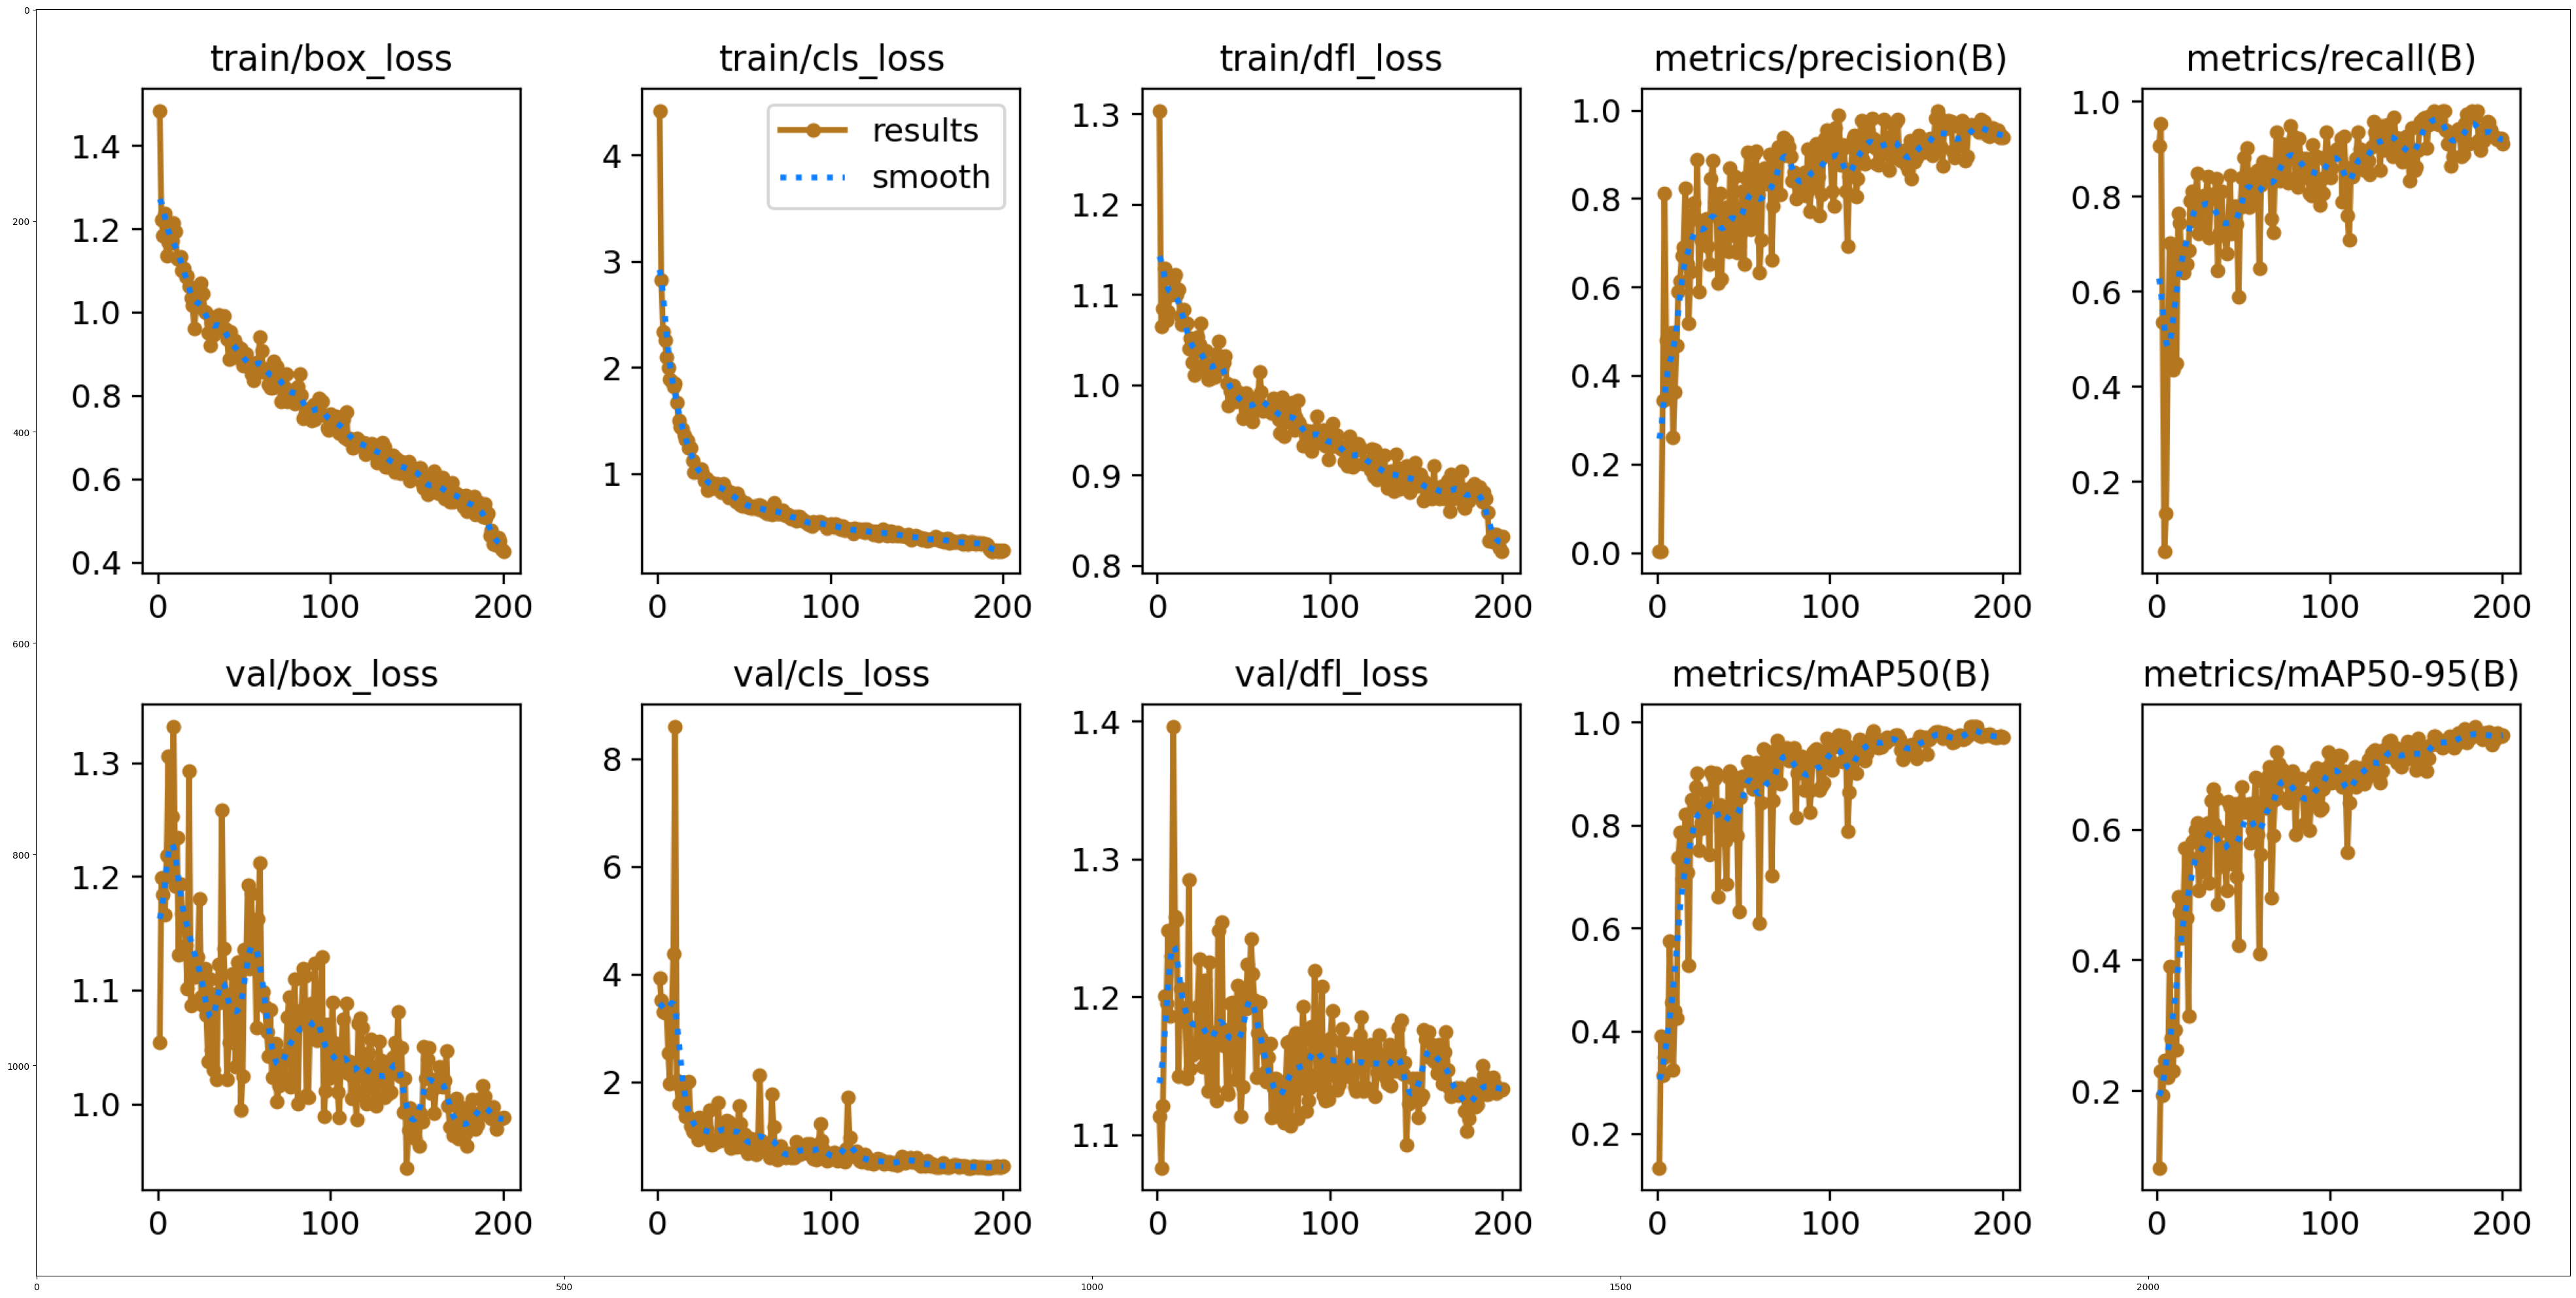

In [34]:
training_save_dir = '/kaggle/working/' + str(results.save_dir)

plt.figure(figsize=(50, 50))
img = cv2.imread(os.path.join(training_save_dir, 'results.png'))
plt.imshow(img)
plt.show()

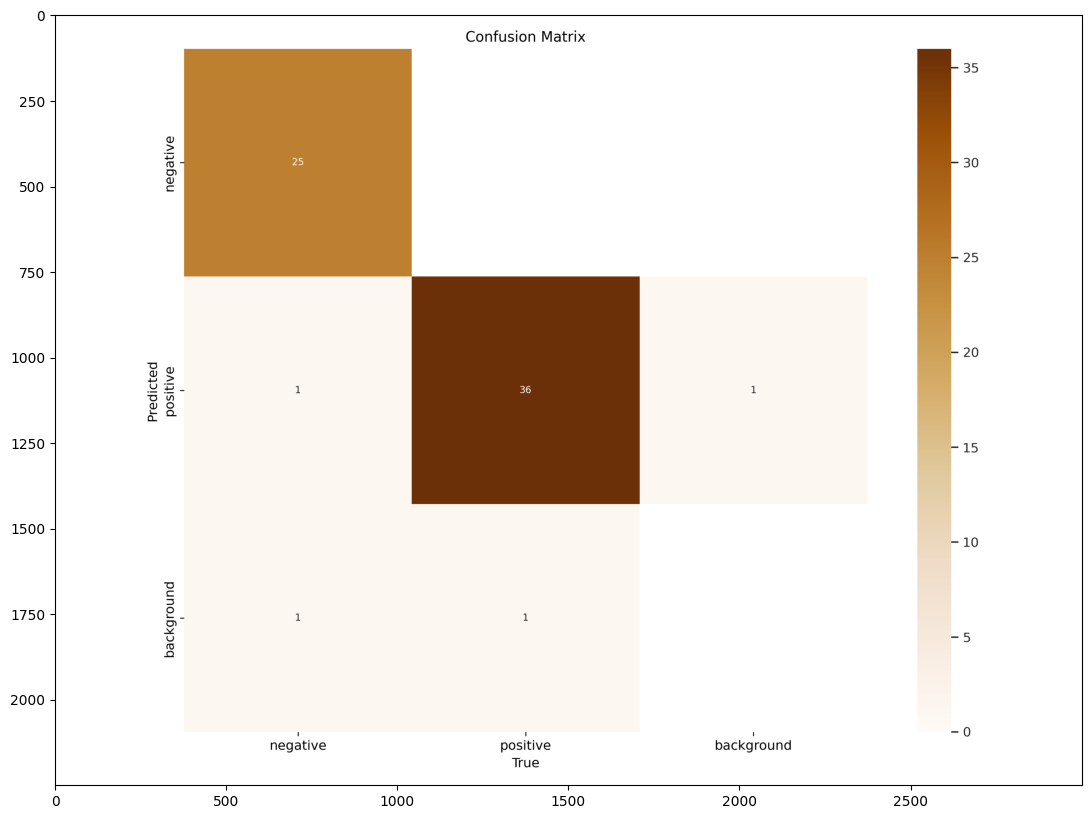

In [17]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

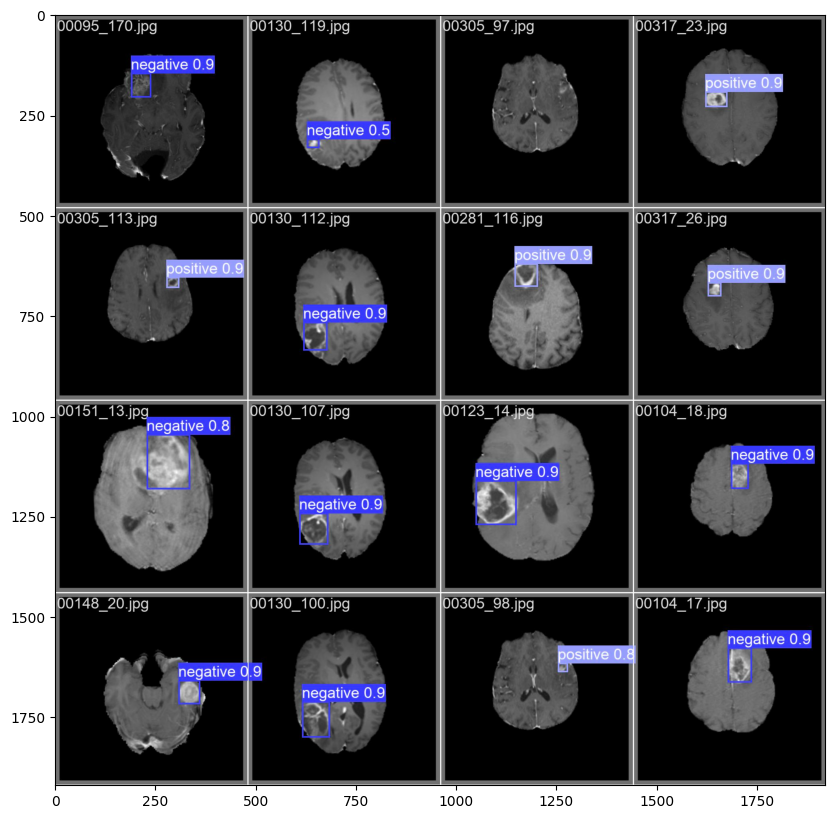

In [18]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

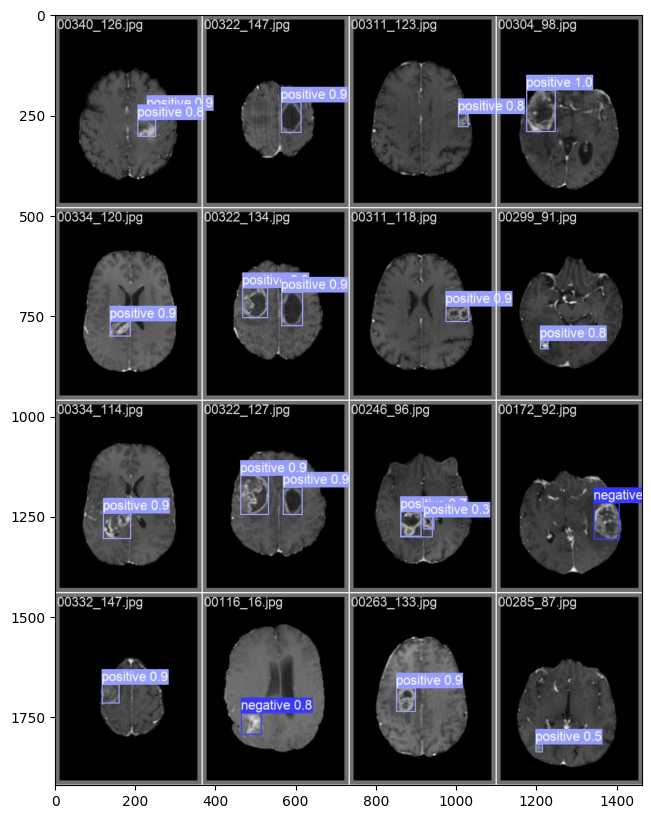

In [19]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(training_save_dir, 'val_batch1_pred.jpg'))
plt.imshow(img)
plt.show()

In [20]:
trained_model = YOLO(training_save_dir + '/weights/best.pt')
predictions = trained_model.predict(
    source="/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test",
    conf=0.4, save_txt=True, save_conf=True)


image 1/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_101.jpg: 640x640 1 negative, 6.7ms
image 2/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_109.jpg: 640x640 1 negative, 7.0ms
image 3/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_111.jpg: 640x640 1 negative, 6.8ms
image 4/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_117.jpg: 640x640 1 negative, 7.3ms
image 5/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_121.jpg: 640x640 1 negative, 7.0ms
image 6/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_126.jpg: 640x640 1 negative, 6.9ms
image 7/75 /kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_134.jpg: 640x640 1 negative, 6.8ms
image 8/75 /kaggle/input/brain-tumor-object-det

In [21]:
#print(predictions[4])

In [22]:
predictions_save_dir = '/kaggle/working/' + predictions[0].save_dir + '/labels'

In [23]:
def draw_bbox(file_path, filename, img):
    with open(os.path.join(file_path, f'{filename}.txt'),'r') as f:
        labels = f.readlines()
        labels = labels[0].split(' ')
        print(labels)
        f.close()

    tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
    x_pt1 = int((x - w/2) * img.shape[1])
    y_pt1 = int((y - h/2) * img.shape[0])
    x_pt2 = int((x + w/2) * img.shape[1])
    y_pt2 = int((y + h/2) * img.shape[0])

    if tumor_class == 0:
        colour = (255, 0, 0)
        label = 'Negative'
    else:
        colour = (0, 255, 0)
        label = 'Positive'
    if len(labels) > 5:
        prob = float(labels[5])
        prob = round(prob, 1)
        prob = str(prob)
        label = label + ' ' + prob

    cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)
    cv2.putText(img, label, (x_pt1, y_pt1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, colour, 1)

['0', '0.438444', '0.672237', '0.174897', '0.179589', '0.650503\n']
['0', '0.414319', '0.670188', '0.133803', '0.180751']


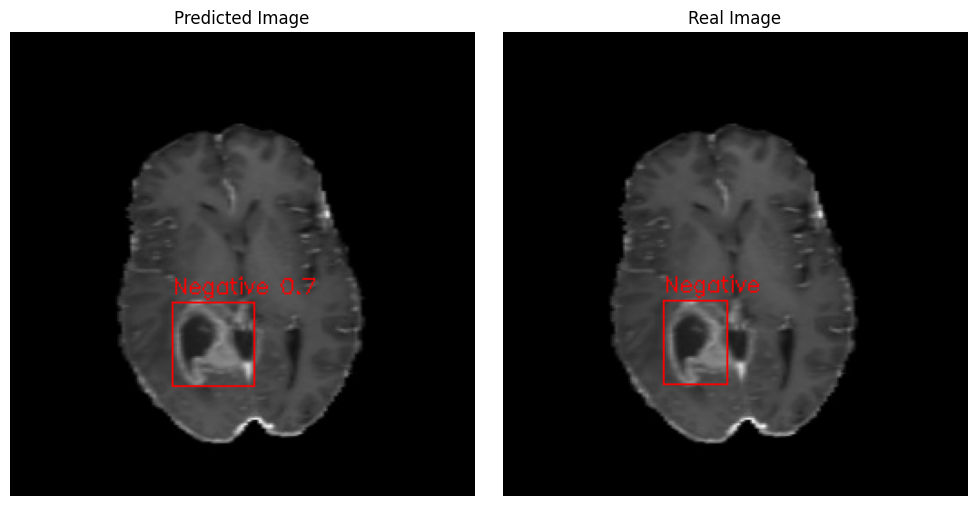

In [24]:
files = os.listdir(predictions_save_dir)
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]

img_pred = cv2.imread(os.path.join('dataset/images/test', f'{random_file}.jpg'), 1)
img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
draw_bbox(predictions_save_dir, random_file, img_pred)

img_real = cv2.imread(os.path.join('dataset/images/test', f'{random_file}.jpg'), 1)
img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
draw_bbox('dataset/labels/test', random_file, img_real)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_pred)
axes[0].set_title('Predicted Image')
axes[0].axis('off')

axes[1].imshow(img_real)
axes[1].set_title('Real Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [25]:
text = """
path: /kaggle/working/dataset
train: images/train
val: images/test

# Classes
nc: 2
names: ['negative','positive']
"""
with open("./test.yaml", 'w') as file:
    file.write(text)

In [26]:
metrics = trained_model.val(data="test.yaml")  # no arguments needed, dataset and settings remembered

Ultralytics YOLOv8.1.35 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)


val: Scanning /kaggle/working/dataset/labels/test... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<00:00, 1198.82it/s]

val: New cache created: /kaggle/working/dataset/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.46it/s]


                   all         75         81      0.853      0.787      0.895       0.66
              negative         75         81      0.853      0.787      0.895       0.66
Speed: 3.3ms preprocess, 5.5ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/val


In [27]:
test_save_dir = '/kaggle/working/' + str(metrics.save_dir)

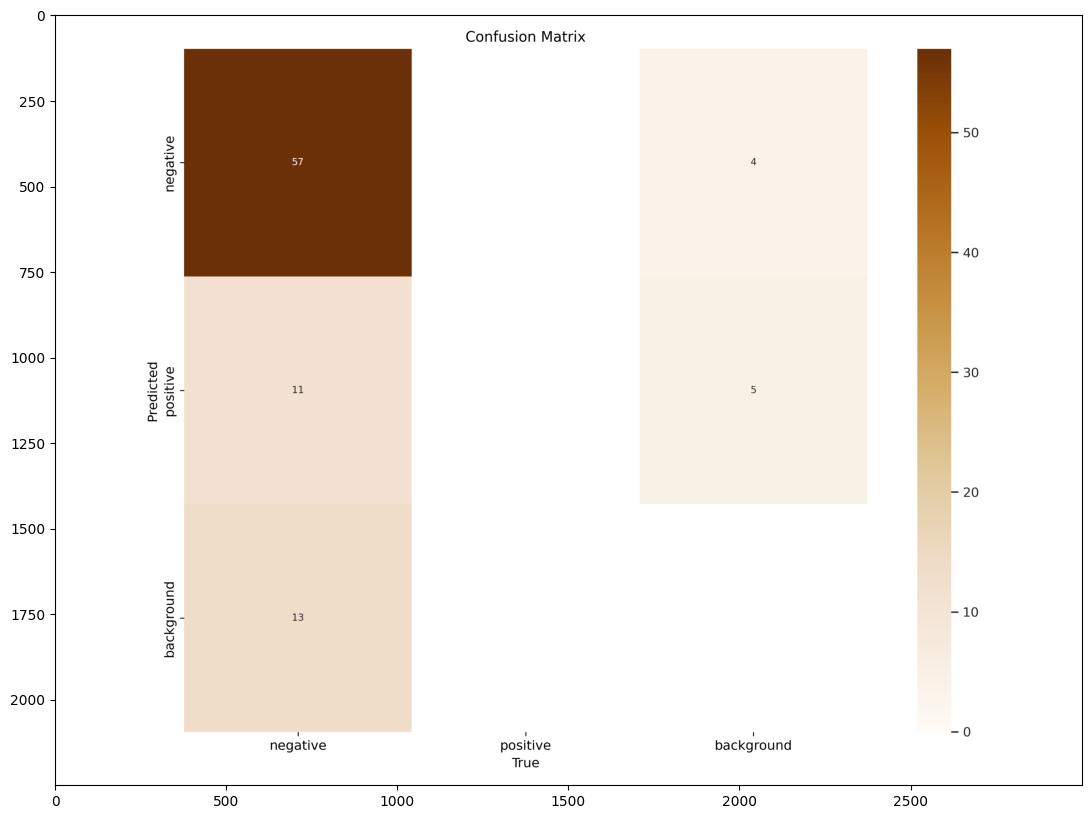

In [28]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

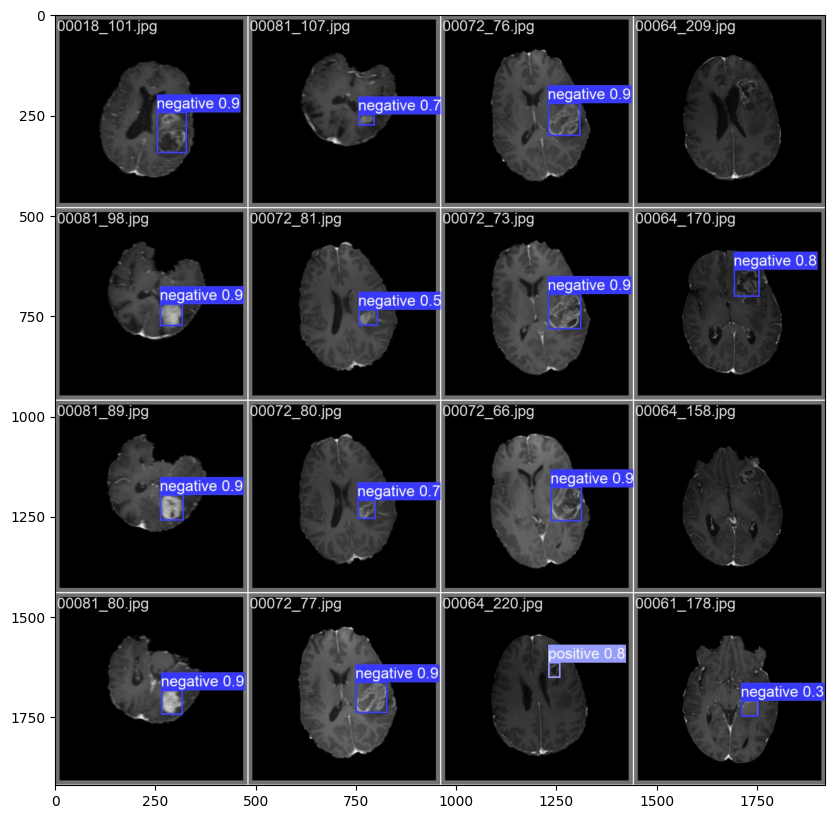

In [29]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

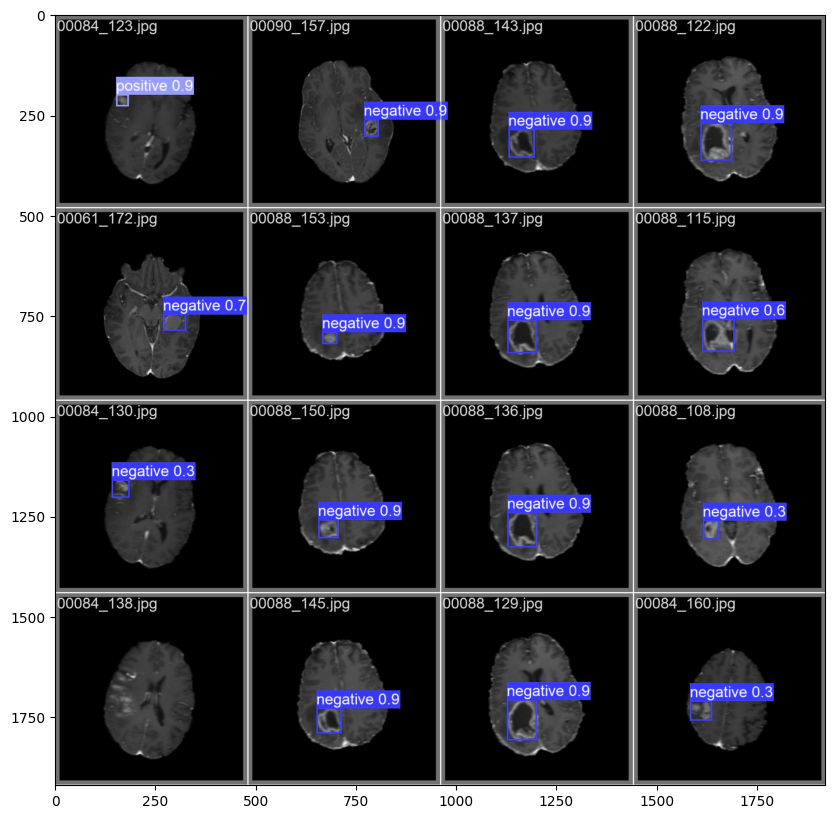

In [30]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'val_batch1_pred.jpg'))
plt.imshow(img)
plt.show()